✅ R² Score: 0.941
✅ RMSE: 77.17 kWh
📊 Average energy in dataset: 188.27 kWh


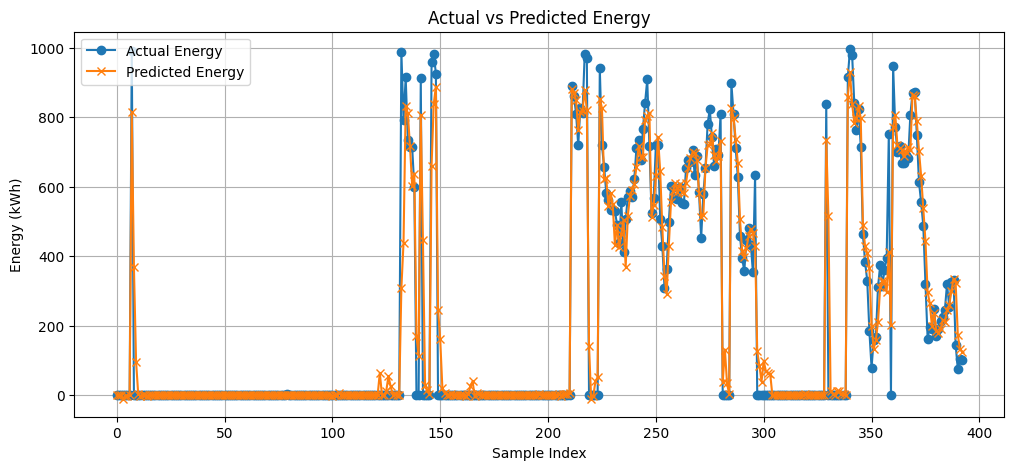

✅ Predictions saved to xgboost_predictions.xlsx


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# -------------------- Load Data --------------------
df = pd.read_excel("testdata.xlsx", engine='openpyxl')

# Clean numeric columns
for col in ["Speed (m/s)", "Direction", "Energy(kWh)"]:
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.dropna(inplace=True)

# -------------------- Feature Engineering --------------------
df['hour'] = df['Date'].dt.hour
df['minute'] = df['Date'].dt.minute
df['weekday'] = df['Date'].dt.weekday

# Circular features for direction
df['dir_sin'] = np.sin(np.deg2rad(df['Direction']))
df['dir_cos'] = np.cos(np.deg2rad(df['Direction']))

# Wind speed cubed
df['speed_cubed'] = df['Speed (m/s)'] ** 3

# Lag features for energy and speed
for lag in range(1, 4):
    df[f'Energy_lag{lag}'] = df['Energy(kWh)'].shift(lag)
    df[f'Speed_lag{lag}'] = df['Speed (m/s)'].shift(lag)

# Rolling mean & std (window=3)
df['Energy_roll_mean'] = df['Energy(kWh)'].rolling(3).mean()
df['Energy_roll_std'] = df['Energy(kWh)'].rolling(3).std()
df['Speed_roll_mean'] = df['Speed (m/s)'].rolling(3).mean()

df.dropna(inplace=True)

# -------------------- Features & Target --------------------
feature_cols = [
    'Speed (m/s)', 'speed_cubed', 'hour', 'minute', 'weekday',
    'dir_sin', 'dir_cos',
    'Energy_lag1','Energy_lag2','Energy_lag3',
    'Speed_lag1','Speed_lag2','Speed_lag3',
    'Energy_roll_mean','Energy_roll_std','Speed_roll_mean'
]
X = df[feature_cols]
y = df['Energy(kWh)']

# -------------------- Train/Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# -------------------- Train XGBoost --------------------
model = XGBRegressor(
    n_estimators=500, 
    max_depth=6, 
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# -------------------- Predict & Evaluate --------------------
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ R² Score: {r2:.3f}")
print(f"✅ RMSE: {rmse:.2f} kWh")
print(f"📊 Average energy in dataset: {y.mean():.2f} kWh")

# -------------------- Graphical Comparison --------------------
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual Energy', marker='o')
plt.plot(y_pred, label='Predicted Energy', marker='x')
plt.title('Actual vs Predicted Energy')
plt.xlabel('Sample Index')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.grid(True)
plt.show()
# -------------------- Save Predictions --------------------
output_df = pd.DataFrame({
    'Actual_Energy': y_test.values,
    'Predicted_Energy': y_pred
})

output_df.to_excel("xgboost_predictions.xlsx", index=False)
print("✅ Predictions saved to xgboost_predictions.xlsx")


✅ 10-min interval forecast saved to xgboost_forecast_next_day.xlsx


C:\Users\PSP LAB\AppData\Local\Temp\ipykernel_8600\2097856481.py:50: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(start=start_time, periods=steps_ahead, freq='10T')


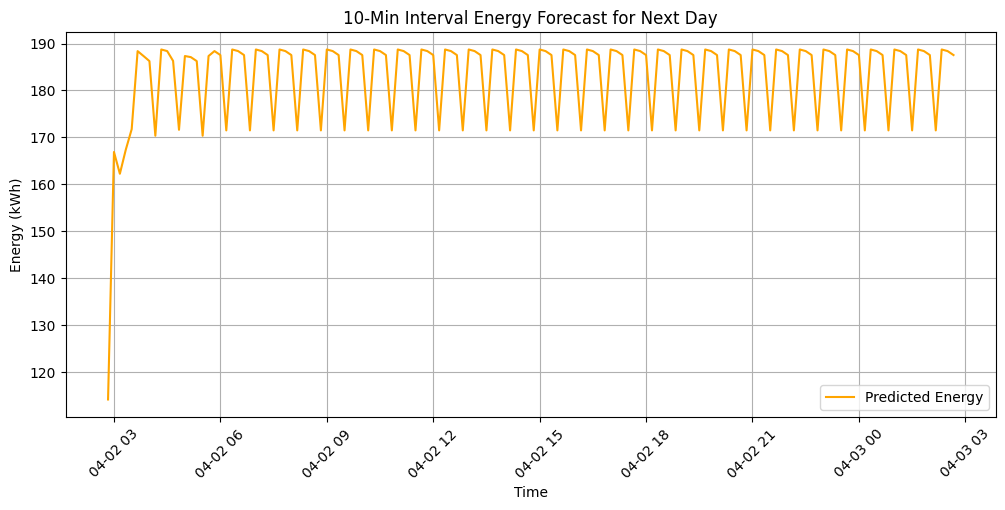

In [2]:
import pandas as pd
import numpy as np

# -------------------- Parameters --------------------
steps_ahead = 144  # 24h × 6 (10-min intervals)
lags = 3           # same as used in training

# -------------------- Prepare last rows for prediction --------------------
last_data = df.iloc[-lags:].copy()  # get last 3 rows to create lag features

predictions = []

for i in range(steps_ahead):
    # Build features for prediction
    features = {
        'Speed (m/s)': last_data['Speed (m/s)'].iloc[-1],
        'speed_cubed': last_data['Speed (m/s)'].iloc[-1] ** 3,
        'hour': (last_data.index[-1] + 1) % 24,   # increment hour if needed
        'minute': ((last_data.index[-1] * 10 + 10) % 60),  # 10-min steps
        'weekday': last_data['weekday'].iloc[-1],  # assume same day for simplicity
        'dir_sin': np.sin(np.deg2rad(last_data['Direction'].iloc[-1])),
        'dir_cos': np.cos(np.deg2rad(last_data['Direction'].iloc[-1])),
    }

    # Lag features
    for lag in range(1, lags+1):
        features[f'Energy_lag{lag}'] = last_data['Energy(kWh)'].iloc[-lag]
        features[f'Speed_lag{lag}'] = last_data['Speed (m/s)'].iloc[-lag]

    # Rolling features
    features['Energy_roll_mean'] = last_data['Energy(kWh)'].rolling(lags).mean().iloc[-1]
    features['Energy_roll_std'] = last_data['Energy(kWh)'].rolling(lags).std().iloc[-1]
    features['Speed_roll_mean'] = last_data['Speed (m/s)'].rolling(lags).mean().iloc[-1]

    # Convert to DataFrame
    X_input = pd.DataFrame([features])[feature_cols]

    # Predict next energy
    y_pred = model.predict(X_input)[0]
    predictions.append(y_pred)

    # Append predicted row to last_data for next iteration
    new_row = last_data.iloc[-1].copy()
    new_row['Energy(kWh)'] = y_pred
    last_data = pd.concat([last_data, pd.DataFrame([new_row])], ignore_index=True)
    last_data = last_data.iloc[-lags:]  # keep only last 'lags' rows

# -------------------- Build Forecast DataFrame --------------------
start_time = df['Date'].iloc[-1] + pd.Timedelta(minutes=10)
dates = pd.date_range(start=start_time, periods=steps_ahead, freq='10T')

forecast_df = pd.DataFrame({
    'Date': dates,
    'Pred_Energy(kWh)': predictions
})

# -------------------- Save Forecast --------------------
forecast_df.to_excel("xgboost_forecast_next_day.xlsx", index=False)
print("✅ 10-min interval forecast saved to xgboost_forecast_next_day.xlsx")

# -------------------- Plot Forecast --------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(forecast_df['Date'], forecast_df['Pred_Energy(kWh)'], label='Predicted Energy', color='orange')
plt.title('10-Min Interval Energy Forecast for Next Day')
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


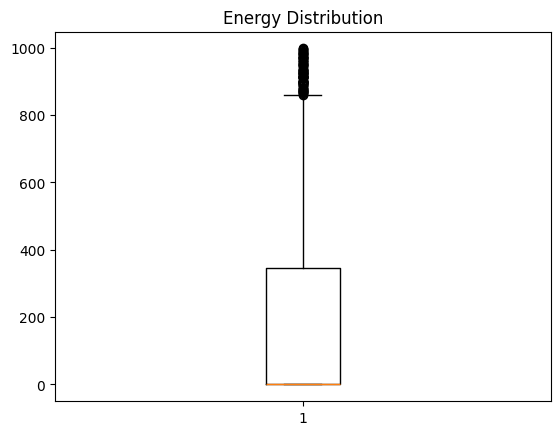

In [3]:
plt.boxplot(df['Energy(kWh)'])
plt.title("Energy Distribution")
plt.show()
